In [5]:
from pinnsform.util import *
from pinnsform.model import PINN, FLS, FLW, FullWaveletC
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = os.getcwd()

def visualize_mesh(mesh, title = "Predicted u(x,t)"):
    plt.figure(figsize=(8,6))
    plt.imshow(mesh, extent=[0,np.pi*2,1,0], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(title)
    plt.colorbar()
    #plt.tight_layout()
    #plt.savefig('./1dreaction_pinnsformer_pred.png')
    plt.show()

In [6]:
#model_path = os.path.join(base_dir, "results", "ThreeModels_32Bit_LBFGS", 'run', "PINN", "seed_0", "trained_model.pth")
model_path = os.path.join(base_dir, "results", "SixModels_32Bit_LBFGS_TS", '20240912_145058', "FullWavelet_correct", "seed_0", "trained_model.pth")

In [7]:
device = 'cuda'

model = FullWaveletC(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
RHO = 5.0

def loss_fn(model, mesh, b_left, b_right, initial, initial_values):
    # pde
    u = f(model, mesh)
    pde_residue = df(model, mesh, wrt=1) - RHO*u*(1.0-u)
    pde_loss = pde_residue.pow(2)

    # boundary
    boundary_residue = f(model, b_left) - f(model, b_right)
    boundary_loss = boundary_residue.pow(2)

    # initial
    initial_residue = f(model, initial) - initial_values
    initial_loss = initial_residue.pow(2)

    return pde_loss, boundary_loss, initial_loss

def intial_value_function(x):
    return torch.exp(- (x - torch.pi)**2 / (2*(torch.pi/4.0)**2))


def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(RHO*t) / ( h(x) * np.exp(RHO*t) + 1 - h(x))

problem_domain = ([0, 2*np.pi], [0, 1])

In [14]:
train_points = (51, 51) 

# 51x51 mesh as list
np_mesh = generate_mesh(train_points, problem_domain)
# 51x51 mesh as list with temporal sequence for every point
sequence_mesh = make_temporal_sequence(np_mesh, num_step=5, step=1e-3)
# flatten the temporal sequence for normal models
np_mesh_sequence = listify_sequence(sequence_mesh)
# make Mesh object of torch tensors
mesh = torchify(np_mesh_sequence, device, True)
boundaries = torchified_borders(np_mesh_sequence, problem_domain, device, False)

In [13]:
train_points = (101, 101)
mesh, boundaries = generate_mesh_object(train_points, domain=problem_domain, device=device, full_requires_grad=True, border_requires_grad=False)


In [15]:
b_left = boundaries[0][0]
b_right = boundaries[0][1]
initial = boundaries[1][0]

with torch.no_grad():
    initial_values = intial_value_function(initial.part[0])   #torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))

loss_function = partial(loss_fn, mesh=mesh, b_left=b_left, b_right=b_right, initial=initial, initial_values=initial_values)

In [16]:
pde_loss, boundary_loss, initial_loss = loss_function(model)

In [18]:
prediction = np.reshape(f(model, mesh).detach().cpu().numpy(), (train_points[0], train_points[1]*5))

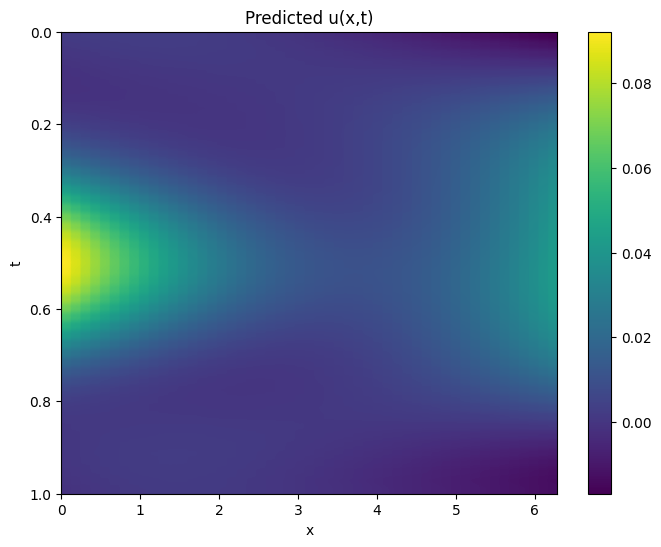

In [19]:
visualize_mesh(prediction)

In [21]:
pde_loss_np = pde_loss.detach().cpu().numpy()
pde_loss_mesh = np.reshape(pde_loss_np, (train_points[0], train_points[1]*5))

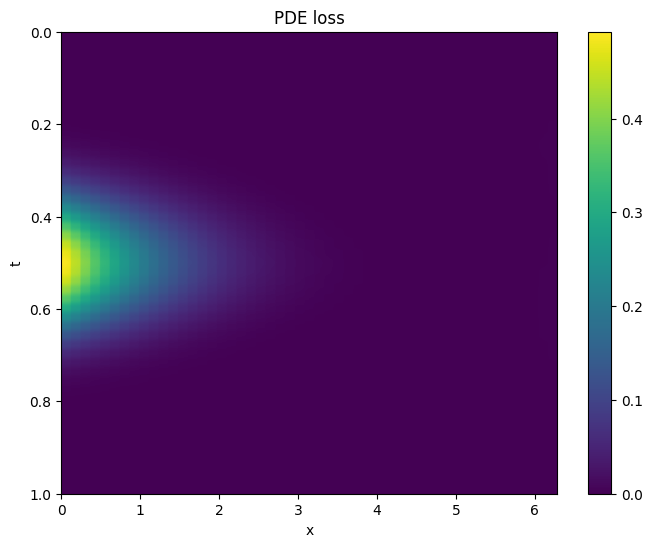

In [22]:
visualize_mesh(pde_loss_mesh, "PDE loss")

In [24]:
boundary_loss

tensor([[1.6121e-05],
        [1.5781e-05],
        [1.5458e-05],
        [1.5140e-05],
        [1.4827e-05],
        [1.4526e-05],
        [1.4228e-05],
        [1.3933e-05],
        [1.3645e-05],
        [1.3363e-05],
        [1.3080e-05],
        [1.2801e-05],
        [1.2523e-05],
        [1.2251e-05],
        [1.1975e-05],
        [1.1707e-05],
        [1.1438e-05],
        [1.1166e-05],
        [1.0901e-05],
        [1.0632e-05],
        [1.0363e-05],
        [1.0092e-05],
        [9.8233e-06],
        [9.5571e-06],
        [9.2854e-06],
        [9.0184e-06],
        [8.7508e-06],
        [8.4800e-06],
        [8.2109e-06],
        [7.9411e-06],
        [7.6729e-06],
        [7.4036e-06],
        [7.1374e-06],
        [6.8701e-06],
        [6.6035e-06],
        [6.3387e-06],
        [6.0745e-06],
        [5.8086e-06],
        [5.5500e-06],
        [5.2900e-06],
        [5.0347e-06],
        [4.7825e-06],
        [4.5315e-06],
        [4.2830e-06],
        [4.0401e-06],
        [3

In [67]:
initial_loss.shape
initial_loss_np = initial_loss.detach().cpu().numpy()

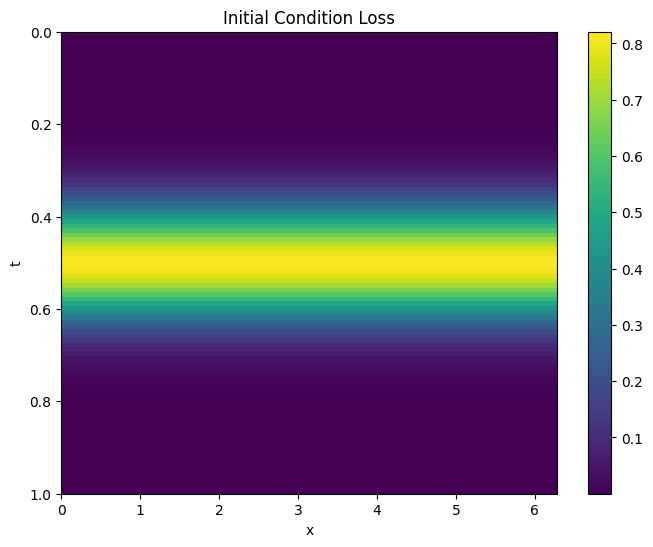

In [68]:
visualize_mesh(initial_loss_np, "Initial Condition Loss")

In [71]:
np.sum(initial_loss_np)

18.157671

In [78]:
np.sum(pde_loss_mesh, axis=0)[0]

12.259677